In [2]:

import Models 
from train_test_validat import *
from self_attention import *
import  ecg_get_data 
import matplotlib.pyplot as plt
import ecg_plot

import torch
import torch.utils.data as Data
import random

import time
import os
import gc

random_seed = 2
torch.manual_seed(random_seed)    # reproducible
torch.cuda.manual_seed_all(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime()) 

In [3]:
data_path =  './npy_ECG//' #路径
lable_path = './label.npy'

EcgChannles_num = 12
EcgLength_num = 5000

In [4]:
x = ecg_get_data.load_data(data_path,EcgChannles_num=EcgChannles_num,EcgLength_num=EcgLength_num)
y = ecg_get_data.load_label(lable_path)

100%|██████████| 1698/1698 [00:16<00:00, 102.92it/s]


In [46]:
x.shape

(1698, 12, 5000)

In [47]:
import scipy.io as io
io.savemat("./dataname.mat", {'data': x})

In [39]:
from __future__ import division
import numpy
from matplotlib import pyplot

import pycwt 
from pycwt.helpers import find

In [57]:
t0 = 0
dt = 0.002
dat = x[0,0,:]
N = dat.size
t = numpy.arange(0, N) * dt + t0
p = numpy.polyfit(t - t0, dat, 1)
dat_notrend = dat - numpy.polyval(p, t - t0)
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset
mother = pycwt.Morlet(4)
s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 7 / dj  # Seven powers of two with dj sub-octaves
alpha, _, _ = pycwt.ar1(dat)  # Lag-1 autocorrelation for red noise

In [58]:
wave, scales, freqs, coi, fft, fftfreqs = pycwt.cwt(dat_norm, dt, dj, s0, J,mother)

In [59]:
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs

In [60]:
power /= scales[:, None]

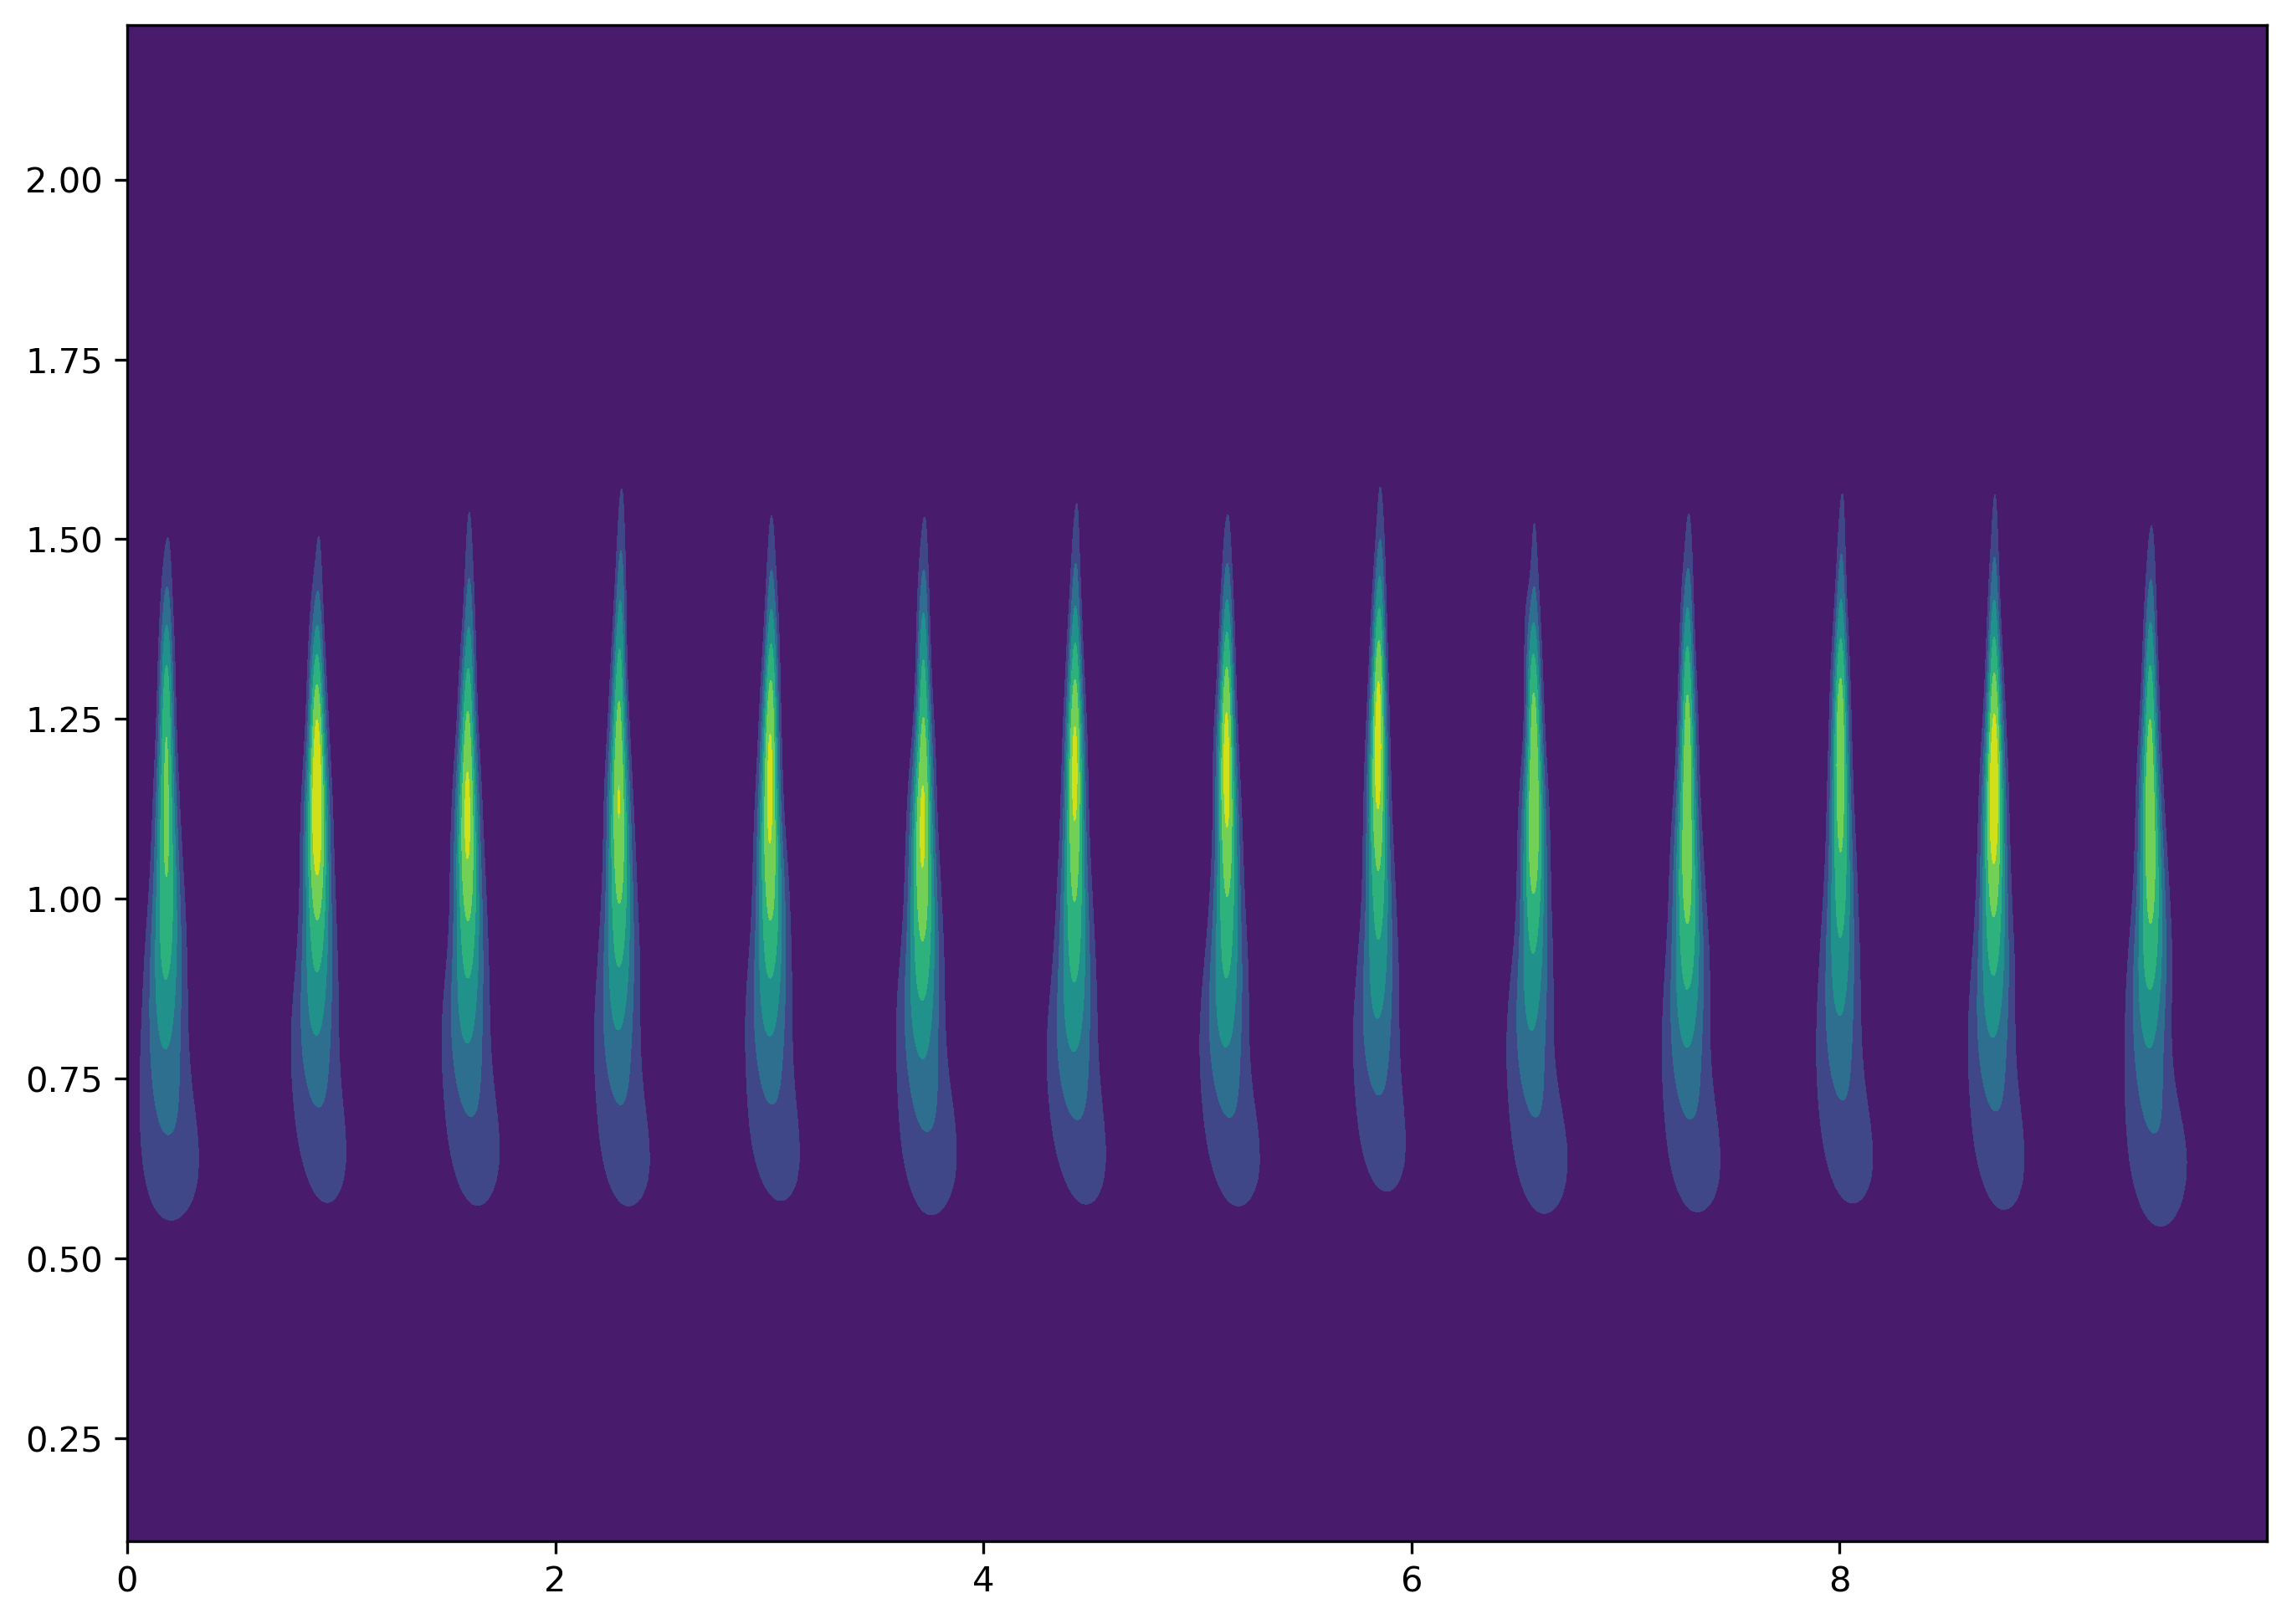

In [66]:
# Prepare the figure
pyplot.close('all')
pyplot.ioff()
figprops = dict(figsize=(11, 8), dpi=300)
fig = pyplot.figure(**figprops)
# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = pyplot.axes()
bx.contourf(t, np.log10(freqs), power,cmap='viridis')
Yticks = 2 ** numpy.arange(numpy.ceil(np.log10(freqs.min())),
                           numpy.ceil(np.log10(freqs.max())))
pyplot.show()